# (Convolutional/Variational) Autoencoders

## Import Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# to hide warnings or atleast some of them (caused by mapping with lambda)
# the warnings are not present in colab
import logging
logging.getLogger("tensorflow").disabled = True

## Load Dataset

In [233]:
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

## Inspect Dataset

(28, 28)
(28, 28)
(28, 28)
(28, 28)
(28, 28)


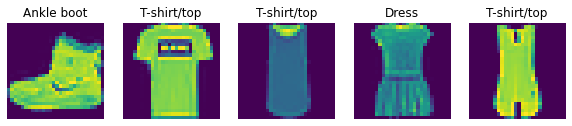

In [33]:
# Declare which number(index) corresponds to which class
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, ax = plt.subplots(1, 5, figsize=(10,10))
for index, [image, label] in enumerate(zip(train_images[0:5], train_labels[0:5])):
    ax[index].imshow(image)
    ax[index].set_title(class_names[label])
    ax[index].axis('off')
    print(image.shape)

## Data Pipeline

In [234]:
# combine images and labels into a tf dataset
train_images = tf.data.Dataset.from_tensor_slices(train_images.reshape(-1, 28, 28, 1))
train_labels = tf.data.Dataset.from_tensor_slices(train_labels)
test_images = tf.data.Dataset.from_tensor_slices(test_images.reshape(-1, 28, 28, 1))
test_labels = tf.data.Dataset.from_tensor_slices(test_labels)

train_dataset = tf.data.Dataset.zip((train_images, train_labels))
test_dataset = tf.data.Dataset.zip((test_images, test_labels))
                                              

# shuffle data
train_dataset = train_dataset.shuffle(64)
test_dataset = test_dataset.shuffle(64)                                                


# create minibatches
train_dataset = train_dataset.batch(64)
test_dataset = test_dataset.batch(64)


# normalize images and encode labels onehot
train_dataset = train_dataset.map(lambda image, label: 
                                          (image/255, tf.one_hot(label, 10)), 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

test_dataset = test_dataset.map(lambda image, label: 
                                          (image/255, tf.one_hot(label, 10)), 
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

# we store a non prefetched test_dataset to inspect the progess of our model later
test_dataset_clean = test_dataset

# Prefetch
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Convolutional Autoencoder

In [162]:
from tensorflow.keras import Model, Input

class ConvAE(Model):

  def __init__(self, embedding_size = 10):
    super(ConvAE, self).__init__()

    self.encoder = [
            tf.keras.layers.Conv2D(
                              filters = 32,
                              kernel_size = 4,
                              strides = 1,
                              padding = 'same',
                              activation = 'relu',
                              input_shape = (28, 28, 1)),
         
            tf.keras.layers.Conv2D(
                              filters = 64, 
                              kernel_size = 3, 
                              strides = (2, 2), 
                              activation='relu'),
         
            tf.keras.layers.Conv2D(
                              filters = 128, 
                              kernel_size = 3, 
                              strides = (2, 2), 
                              activation ='relu'),
         
            tf.keras.layers.Flatten(),
        
            tf.keras.layers.Dense(
                              embedding_size,
                              activation = None),
        ]


    self.decoder = [
            tf.keras.layers.InputLayer(input_shape=(embedding_size)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=2, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=2, strides=1, padding='same',
                activation = "sigmoid"),
        ]
  
  # Helper function to get a nice summary with 
  # my_model.sum_helper().summary()
  # mode defines which part of the model is returned as a summary

  def sum_helper(self, mode = "encode"):
        if mode == "encode":
          x = Input(shape=(28, 28, 1))
          return Model(inputs=[x], outputs=self.call(x, mode))
        if mode == "decode":
          x = Input(shape=(10))
          return Model(inputs=[x], outputs=self.call(x, mode))


  def call(self, x, mode = "encode"):
    
    if mode == "encode":
      for layer in self.encoder:
        x = layer(x)
      return x

    elif mode == "decode":
      for layer in self.decoder:
        x = layer(x)
      return x

    else:
      return "No mode was selected (encode or decode)"

## Test encoder and decoder

In [170]:
tf.keras.losses.MSE
model = ConvAE(10);
for img_batch, label_batch in train_dataset.take(1):
    a = tf.keras.losses.MSE(img_batch, model(model(img_batch, "encode"), "decode")).numpy()

In [171]:
np.mean(a)

0.17376177

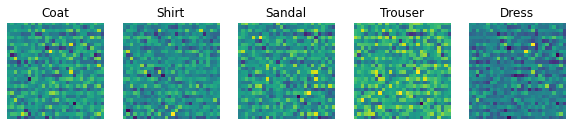

In [161]:
model = ConvAE(10);
for img_batch, label_batch in train_dataset.take(1):
    de_encoded_imgs = model(model(img_batch, "encode"), "decode").numpy()
    labels = label_batch

fig, ax = plt.subplots(1, 5, figsize=(10,10))
for index, [image, label] in enumerate(zip(de_encoded_imgs[0:5], labels[0:5])):
    ax[index].imshow(image.squeeze())
    ax[index].set_title(class_names[np.where(label == 1)[0][0]])
    ax[index].axis('off')

In [155]:
model.sum_helper("encode").summary()
model.sum_helper("decode").summary()

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_64 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 28, 28, 32)        544       
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 6, 6, 128)         73856     
_________________________________________________________________
flatten_42 (Flatten)         (None, 4608)              0         
_________________________________________________________________
dense_85 (Dense)             (None, 10)                46090     
Total params: 138,986
Trainable params: 138,986
Non-trainable params: 0
_______________________________________________

## Define Training

In [192]:
def train_step(model, input, target, loss_function, optimizer):
    with tf.GradientTape() as tape:
        encoded = model(input, "encode")
        decoded = model(encoded, "decode")
        loss = loss_function(input, decoded) #+ tf.reduce_sum(model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def test(model, test_data, loss_function, training = False):
    # Test over complete test data

    test_loss_aggregator = []

    for (input, target) in test_data:
        encoded = model(input, "encode")
        decoded = model(encoded, "decode")
        sample_test_loss = loss_function(input, decoded)
        test_loss_aggregator.append(np.mean(sample_test_loss.numpy()))
    
    test_loss = np.mean(test_loss_aggregator)
      
    return test_loss

## Train model and observe progress

No handles with labels found to put in legend.


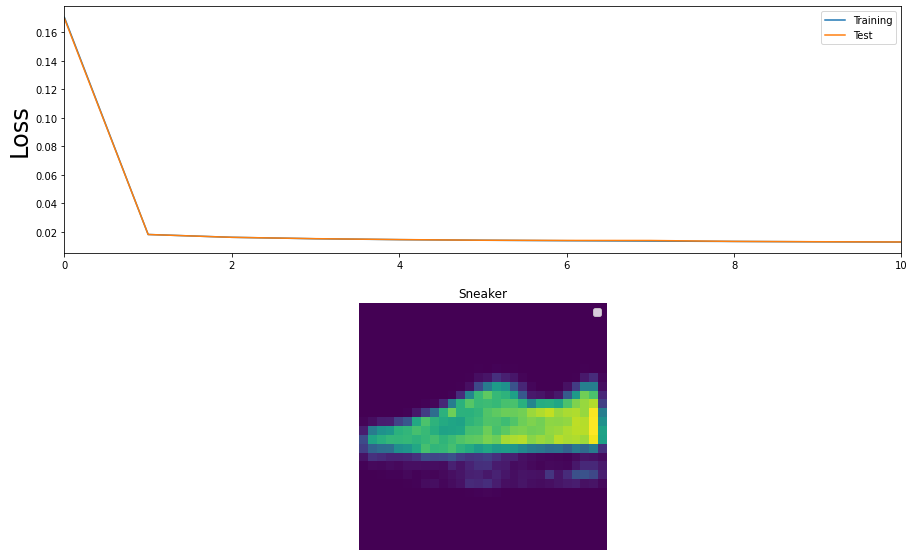

Train loss:  0.012943455707004935
Test loss:  0.013003814
CPU times: user 2min 6s, sys: 3.32 s, total: 2min 9s
Wall time: 2min 10s


In [245]:
%%time
tf.keras.backend.clear_session()
from IPython.display import clear_output

### Hyperparameters
num_epochs = 10
learning_rate = 0.001
embedding_size = 10
running_average_factor = 0.95

model = ConvAE(embedding_size)

# Initialize the loss
mean_squared_error = tf.keras.losses.MSE

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []
test_losses = []

# Testing model performance on train and test data before learning
train_loss = test(model, train_dataset, mean_squared_error)
train_losses.append(train_loss)


test_loss = test(model, test_dataset, mean_squared_error)
test_losses.append(test_loss)

# Train loop for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    # Training
    running_average_loss = 0
    for (input,target) in train_dataset:
        train_loss = np.mean(train_step(model, input, target, mean_squared_error, optimizer))
        running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss
        
    train_losses.append(running_average_loss)
   

    # Testing
    test_loss = test(model, test_dataset, mean_squared_error)
    test_losses.append(test_loss)

    # each epoch we sample 1 image the clean test dataset that we stored earlier
    # and compare it to the models en- and decoding
    test_dataset_clean.shuffle(64)
    for img_batch, label_batch in test_dataset_clean.take(1):
      original = img_batch.numpy()[0]
      reconstructed = model(model(img_batch, "encode"), "decode").numpy()[0]
      label = class_names[np.where(label_batch[0] == 1)[0][0]]

    clear_output(wait=True) 
    fontsize=24
    fig, ax = plt.subplots(2,1,sharex=False,figsize=(15,10))
    ax[0].set_xlim((0,num_epochs))
    ax[0].plot(train_losses,label="Training")
    ax[0].plot(test_losses,label="Test")


    ax[0].set_ylabel("Loss",fontsize=fontsize)
    ax[1].set_xlabel("Epochs",fontsize=fontsize)
    ax[1].imshow(reconstructed.squeeze())

    ax[1].set_title(label)
    ax[1].axis('off')
    
    ax[0].legend()
    ax[1].legend()
    plt.show()

    print('Train loss: ',running_average_loss)
    print('Test loss: ',test_loss)
